# Task 4.2: Explanation Analysis


In [49]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.offline as py
np.random.seed(42)



In [50]:
# Gun incidents data
df_incidents_cleaned = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5', key = 'df')

# Visualize data table
df_incidents_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64        

In [51]:
df_incidents_dt = df_incidents_cleaned.copy()
df_incidents_dt['isKilled'] = df_incidents_dt['n_killed'] > 0


In [71]:
coumns_not_to_drop_dt  = [
                        'isKilled',
                        'latitude',
                        'longitude',
                        'party',
                        'n_arrested', 
                        'n_females',
                        'avg_age_participants',
                        'participant_age_group1', 
                        'density_incident_state',
                        'povertyPercentage', 
                        #'state', 
                        #'n_injured',
                        'danger_index',
                        'male_indicator'
                        'ratio_killed',
                        'danger_metric'
                        ]

old_column_not_to_drop = ['isKilled', 'n_females',
                         'avg_age_participants', 
                         'density_incident_state', 'n_injured', 'n_arrested', 'latitude', 'longitude', 'povertyPercentage'] # ,

# broke all if you add n_killed since is higly correlated : 0.94

all_columns_dt = df_incidents_dt.columns

columns_to_drop_dt = [x for x in all_columns_dt if x not in coumns_not_to_drop_dt]

df_incidents_dt.drop(columns_to_drop_dt, axis = 1, inplace = True)
df_incidents_dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   participant_age_group1  131618 non-null  category
 1   avg_age_participants    131618 non-null  int64   
 2   n_females               131618 non-null  int64   
 3   n_arrested              131618 non-null  int64   
 4   povertyPercentage       131618 non-null  float64 
 5   density_incident_state  131618 non-null  float64 
 6   isKilled                131618 non-null  bool    
dtypes: bool(1), category(1), float64(2), int64(3)
memory usage: 6.3 MB


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Assuming df_incidents_cleaned is your original DataFrame

UMBALANCE_DATA = False

if not UMBALANCE_DATA:

    # Select 100 samples where isKilled is True
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=5000, random_state=42)

    # Select 100 samples where isKilled is False
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=5000, random_state=42)
else:
    
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=500, random_state=42)
    
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=3000, random_state=42) 


# Concatenate the balanced samples into a new DataFrame
balanced_df = pd.concat([killed_samples, not_killed_samples])

# Shuffle the rows in the new DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced DataFrame
#print(balanced_df.head())  # You can replace this with your desired way of using the balanced dataset



target = balanced_df['isKilled']
df_dt = balanced_df.drop(['isKilled'], axis = 1)
df_dt = pd.get_dummies(df_dt)
df_dt.info()

random_state = 42
test_size = 0.2
max_depth = 40
#X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)
train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   avg_age_participants               10000 non-null  int64  
 1   n_females                          10000 non-null  int64  
 2   n_arrested                         10000 non-null  int64  
 3   povertyPercentage                  10000 non-null  float64
 4   density_incident_state             10000 non-null  float64
 5   participant_age_group1_Adult 18+   10000 non-null  bool   
 6   participant_age_group1_Child 0-11  10000 non-null  bool   
 7   participant_age_group1_Teen 12-17  10000 non-null  bool   
dtypes: bool(3), float64(2), int64(3)
memory usage: 420.0 KB


In [73]:
#Preserve the columns of test and train set
train_set_columns = train_set.columns
test_set_columns = test_set.columns

### 1.1 Lime on Decision Tree

In [74]:
#define a decision tree and fit it
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=60, min_samples_leaf=30)
dt = dt.fit(train_set, train_label)

In [75]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [76]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.6547142857142857
Accuracy test set  0.6193333333333333
Precision train set  0.6547446156589548
Recall train set  0.6547142857142857
F1 score train set  0.654697365885214
Support train set  (array([0.65257819, 0.65691104]), array([0.66171429, 0.64771429]), array([0.65711448, 0.65228025]), array([3500, 3500]))


In [77]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [78]:
report_scores(test_label, test_pred_dt)


              precision    recall  f1-score   support

           0       0.62      0.63      0.62      1500
           1       0.62      0.61      0.62      1500

    accuracy                           0.62      3000
   macro avg       0.62      0.62      0.62      3000
weighted avg       0.62      0.62      0.62      3000



In [104]:
test_set.iloc[0]

avg_age_participants                      21
n_females                                  0
n_arrested                                 1
povertyPercentage                        8.9
density_incident_state               0.03168
participant_age_group1_Adult 18+        True
participant_age_group1_Child 0-11      False
participant_age_group1_Teen 12-17      False
Name: 2027, dtype: object

In [79]:
import lime
import lime.lime_tabular
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Choose a sample from the test set for interpretation
sample_index = 0  # Replace with the index of the sample you want to interpret


# Crea un esplainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, class_names=['Not Killed', 'Killed'], discretize_continuous=True)

# Spiega la previsione del modello per l'istanza selezionata
explanation = explainer.explain_instance(test_set.iloc[0] , dt.predict_proba, num_features=len(train_set_columns), top_labels=1)

# Visualizza l'esposizione
explanation.show_in_notebook(show_table=True, show_all=True)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys 

## LIME on K-NN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize model
knn = KNeighborsClassifier(n_neighbors=4)

# Fit the model
knn.fit(train_set, train_label)

# Crea un esplainer LIME
explainer = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, class_names=['Not KIlled', 'Killed'], discretize_continuous=True)

# Spiega la previsione del modello per l'istanza selezionata
explanation = explainer.explain_instance(test_set.iloc[0], knn.predict_proba, num_features=len(train_set.columns), top_labels=1)

# Visualizza l'esposizione
explanation.show_in_notebook(show_table=True, show_all=True)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as

## LIME on Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier


# Create and train two Random Forest models with different criteria
clf_entropy = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='entropy', n_estimators=100)
clf_gini = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='gini', n_estimators=100)

clf_gini.fit(train_set, train_label)
clf_entropy.fit(train_set, train_label)

# Create LIME explainers for both models
explainer_entropy = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, random_state=42)
explainer_gini = lime.lime_tabular.LimeTabularExplainer(train_set.values, feature_names=train_set.columns, random_state=42)


In [82]:
# Explain Lime predictions for the first test set instance
explanation_entropy = explainer_entropy.explain_instance(test_set.iloc[0], clf_entropy.predict_proba, num_features=len(train_set.columns), top_labels=1)
explanation_gini = explainer_gini.explain_instance(test_set.iloc[0], clf_gini.predict_proba, num_features=len(train_set.columns), top_labels=1)

explanation_entropy.show_in_notebook(show_table=True, show_all=True)
explanation_gini.show_in_notebook(show_table=True, show_all=True)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys 

## Shap on Decision Tree

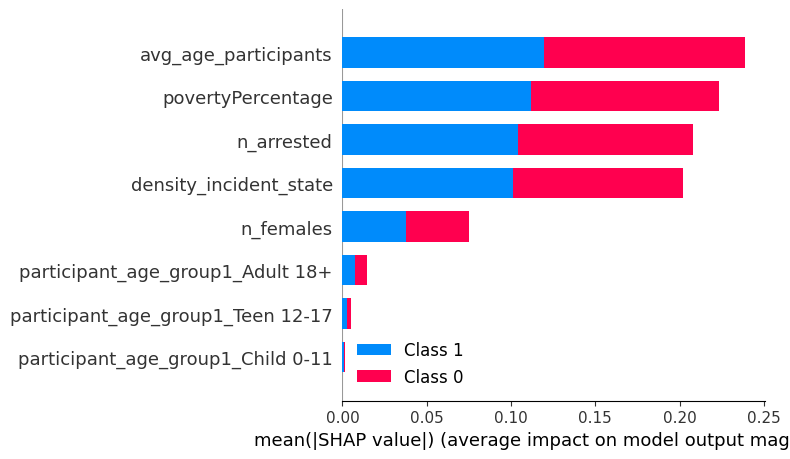

In [83]:
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)

# Create and train DecisionTree model
dtc = DecisionTreeClassifier(max_depth=50, min_samples_split=4)
dtc.fit(train_set, train_label)

# Create a SHAP explainer
explainer = shap.TreeExplainer(dtc)

# Calculate SHAP values
shap_values = explainer.shap_values(test_set)

# Create a SHAP plot for all features
shap.summary_plot(shap_values, test_set, show=True)


## SHAP on Random Forest

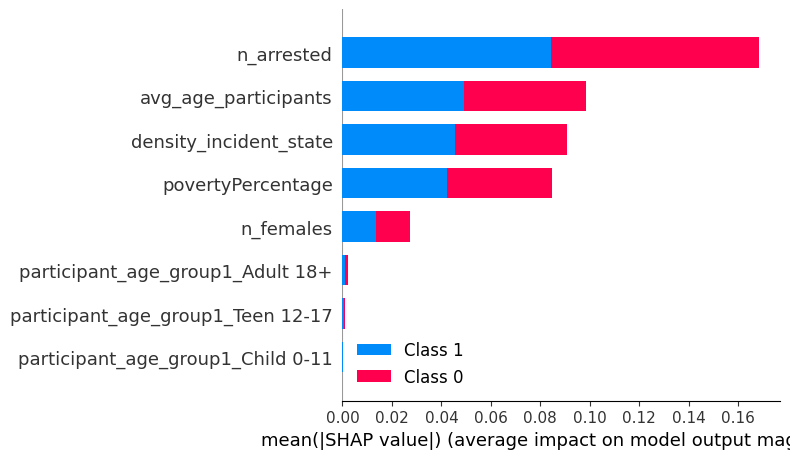

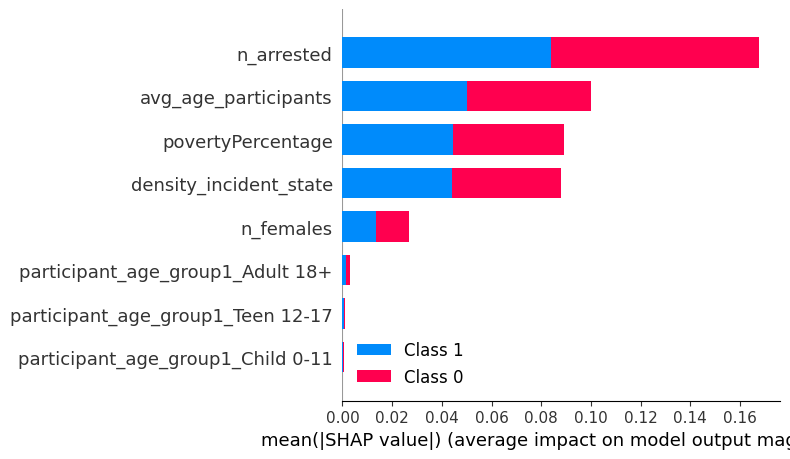

In [84]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Create and train two Random Forest models with different criteria
clf_entropy = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='entropy', n_estimators=100)
clf_gini = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='gini', n_estimators=100)

clf_gini.fit(train_set, train_label)
clf_entropy.fit(train_set, train_label)

# Create SHAP explainers for both models
explainer_entropy = shap.TreeExplainer(clf_entropy)
explainer_gini = shap.TreeExplainer(clf_gini)

# Calculate SHAP values for the test set for both models
shap_values_entropy = explainer_entropy.shap_values(test_set)
shap_values_gini = explainer_gini.shap_values(test_set)

# Create SHAP summary plots for both models
shap.summary_plot(shap_values_entropy, test_set, show=True)
shap.summary_plot(shap_values_gini, test_set, show=True)


In [85]:
shap_values_entropy

[array([[ 4.27566046e-02,  6.18639120e-03,  1.41164722e-01, ...,
          1.21047365e-03,  2.39872635e-05,  1.07623064e-04],
        [ 5.60330469e-03,  3.83851080e-03,  8.49876346e-02, ...,
          5.08508744e-04,  2.61377414e-05,  5.77519702e-04],
        [ 2.98622303e-02,  9.57051250e-04, -7.10948384e-02, ...,
         -1.26908398e-04,  2.88122580e-05, -5.86729314e-04],
        ...,
        [ 8.10227133e-03, -5.66095366e-04, -9.07487612e-02, ...,
          2.04001402e-04,  3.90210533e-05,  7.81227195e-05],
        [-3.01845753e-02,  5.11196348e-03, -7.01857924e-02, ...,
          3.19521226e-04,  5.36860562e-05,  4.84507402e-05],
        [ 3.05554939e-02, -1.56180355e-05, -6.40262929e-02, ...,
         -1.40220361e-04,  4.76659851e-05,  1.40279349e-04]]),
 array([[-4.27566046e-02, -6.18639120e-03, -1.41164722e-01, ...,
         -1.21047365e-03, -2.39872635e-05, -1.07623064e-04],
        [-5.60330469e-03, -3.83851080e-03, -8.49876346e-02, ...,
         -5.08508744e-04, -2.61377414e

In [86]:
# Create a SHAP dependence plot for the 'n_killed' feature
shap.dependence_plot(ind='povertyPercentage', shap_values=shap_values_entropy[0], features=test_set, show=True)
#shap.dependence_plot(ind='n_killed', shap_values_gini[0], features=test_set, show=True)



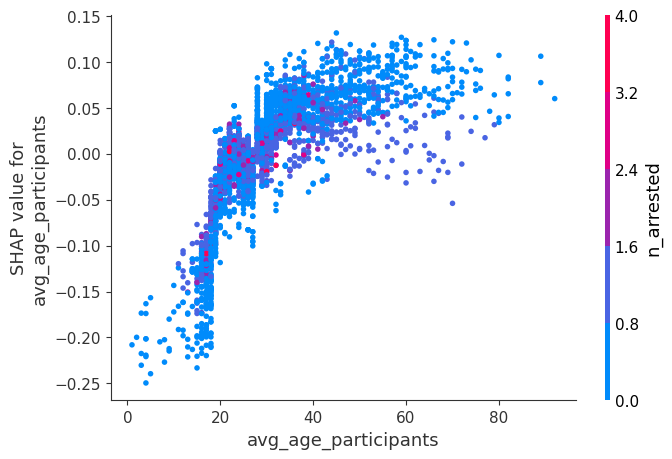

In [87]:
shap.dependence_plot(ind='avg_age_participants', shap_values=shap_values_entropy[1], features=test_set, show=True)


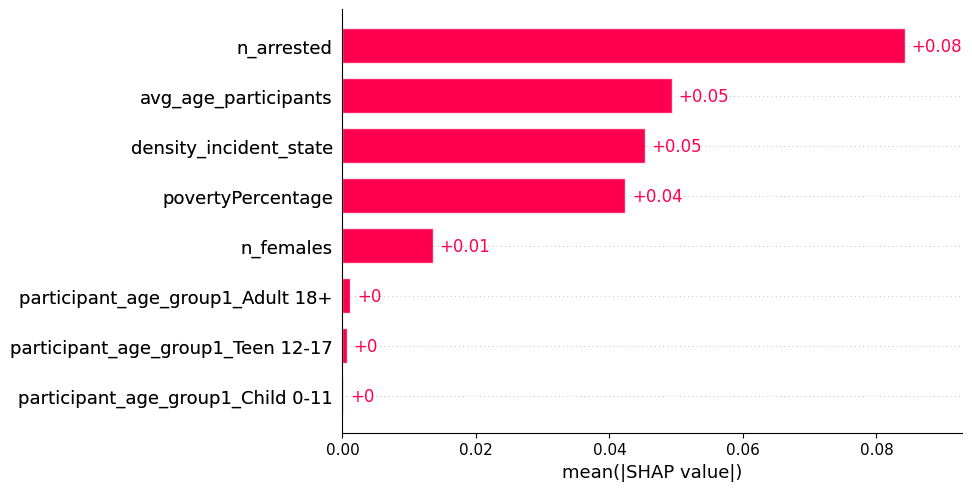

In [88]:
shap_value_bar = explainer_entropy(test_set)
shap.plots.bar(shap_value_bar[:,:,0], max_display=10, show=True)


In [89]:
shap.plots.beeswarm(shap_value_bar[:,:,1])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [90]:
shap.initjs()

In [91]:
shap.plots.force(shap_value_bar[:100,:,0])


In [102]:
shap.plots.waterfall(shap_value_bar[0,:,0]) #False prediction on istance 0


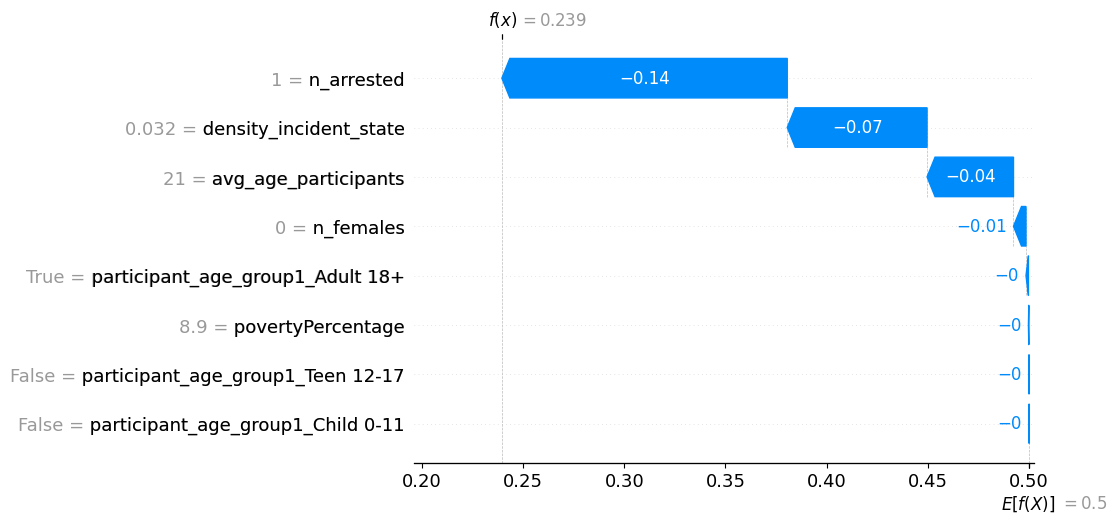

In [103]:
shap.plots.waterfall(shap_value_bar[0,:,1]) #True predicition on instance 0


## EBM

In [94]:
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier

#create ebm model and fit
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(train_set, train_label)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


ExplainableBoostingClassifier()

In [95]:
#Understand the model globally
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/140629623580384/ -->

In [96]:
# Understand individual predictions
ebm_local = ebm.explain_local(train_set, train_label)
show(ebm_local)

<!-- http://127.0.0.1:7001/140629757842944/ -->

In [97]:
from interpret import show
from interpret.data import ClassHistogram
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# train Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(train_set, train_label)

# get predictions
rf_train_predictions = random_forest_model.predict_proba(train_set)[:, 1]
rf_test_predictions = random_forest_model.predict_proba(test_set)[:, 1]

# add predictions as new cols
train_set_with_rf_predictions = train_set.copy()
train_set_with_rf_predictions['rf_predictions'] = rf_train_predictions

test_set_with_rf_predictions = test_set.copy()
test_set_with_rf_predictions['rf_predictions'] = rf_test_predictions

# cteate an EBM model and train it with the predictions of random forest 
ebm_rf = ExplainableBoostingClassifier(random_state=42)
ebm_rf.fit(train_set_with_rf_predictions, train_label) #train_label

# Visualizza la distribuzione delle classi nel dataset
hist = ClassHistogram().explain_data(train_set_with_rf_predictions, train_label)
# Visualizza il modello EBM
ebm_global_rf = ebm.explain_global(name='EBM_RF')
show([hist, ebm_global])

<!-- http://127.0.0.1:7001/140630702742336/ -->
 Open in new window

In [98]:

from sklearn.tree import DecisionTreeClassifier

# new dt
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(train_set, train_label)

# get results on train and test set
dt_train_predictions = decision_tree_model.predict_proba(train_set)[:, 1]
dt_test_predictions = decision_tree_model.predict_proba(test_set)[:, 1]

# add the previosions of dt as new columns
train_set_with_dt_predictions = train_set.copy()
train_set_with_dt_predictions['dt_predictions'] = dt_train_predictions

test_set_with_dt_predictions = test_set.copy()
test_set_with_dt_predictions['dt_predictions'] = dt_test_predictions

# Crate and train the model
ebm_dt = ExplainableBoostingClassifier(random_state=42)
ebm_dt.fit(train_set_with_dt_predictions, train_label)

hist_dt = ClassHistogram().explain_data(train_set_with_dt_predictions, train_label)

# Visualizza il modello EBM per il Decision Tree
ebm_global_dt = ebm_dt.explain_global(name='EBM_DT')
show([hist_dt, ebm_global_dt])

<!-- http://127.0.0.1:7001/140630664818816/ -->
 Open in new window

In [99]:
# Confronta le interpretazioni globali di Random Forest e Decision Tree
show([hist, ebm_global_rf, ebm_global_dt])

<!-- http://127.0.0.1:7001/140630704047424/ -->
 Open in new window